In [4]:
#!pip install tensorflow-addons
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

2.12.0
Num GPUs Available:  0


In [7]:
train_path = r'Data\train'
val_path = r'Data\val'
test_path = r'Data\test'

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    rescale = 1./255,
    preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input
)

test_aug = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input
)

train_generator= train_aug.flow_from_directory(
    train_path,
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

val_generator= test_aug.flow_from_directory(
    val_path,
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

test_generator= test_aug.flow_from_directory(
    test_path,
    color_mode="rgb",
    batch_size=16,
    shuffle = False,
    target_size = (224, 224),
    class_mode="categorical")

num_classes = 3

Found 2354 images belonging to 3 classes.
Found 295 images belonging to 3 classes.
Found 293 images belonging to 3 classes.


In [9]:
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')

    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())

    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()

Epoch 1/10
50/50 [==============================] - 83s 2s/step - loss: 0.9905 - accuracy: 0.5852 - val_loss: 0.3999 - val_accuracy: 0.8339
Epoch 2/10
50/50 [==============================] - 85s 2s/step - loss: 0.2963 - accuracy: 0.8925 - val_loss: 0.1969 - val_accuracy: 0.9424
Epoch 3/10
50/50 [==============================] - 84s 2s/step - loss: 0.1956 - accuracy: 0.9225 - val_loss: 0.3408 - val_accuracy: 0.8576
Epoch 4/10
50/50 [==============================] - 85s 2s/step - loss: 0.1633 - accuracy: 0.9463 - val_loss: 0.1269 - val_accuracy: 0.9525
Epoch 5/10
50/50 [==============================] - 83s 2s/step - loss: 0.1355 - accuracy: 0.9504 - val_loss: 0.1441 - val_accuracy: 0.9356
Epoch 6/10
50/50 [==============================] - 84s 2s/step - loss: 0.1430 - accuracy: 0.9463 - val_loss: 0.2011 - val_accuracy: 0.9051
Epoch 7/10
50/50 [==============================] - 84s 2s/step - loss: 0.1150 - accuracy: 0.9644 - val_loss: 0.1857 - val_accuracy: 0.9220
Epoch 8/10
50/50 [==

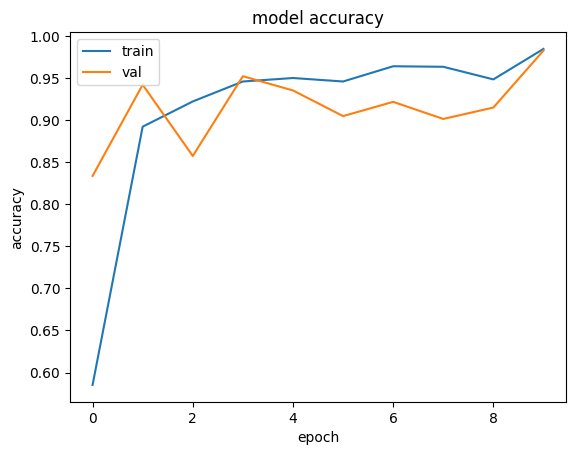

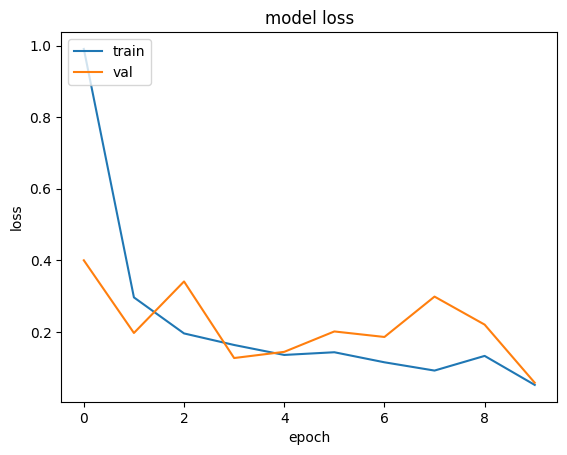

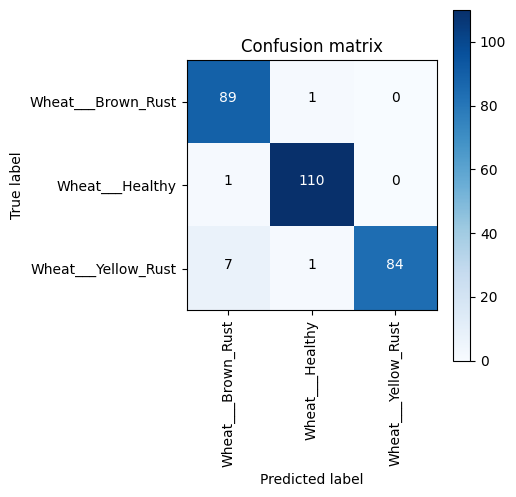

In [7]:
# VGG16

base_model = tensorflow.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top=False,
    input_shape=(224, 224, 3) # Topless
    )

#comparing transfer learning methods, keeping the output layers the same allows for a closer understanding of the differences
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

#To compare pre-trained models accurately,
#train by freezing all parts up to the third-to-last layer.
#Freezing Convolutional Base
for layer in base_model.layers[:-3]:
    layer.trainable = False

import random
best_model_save = tensorflow.keras.callbacks.ModelCheckpoint(
    'VGG16_BestModel' + str(random.randint(0,100000)) + '.hdf5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
)

metrics = ['accuracy']

vgg_model.compile(loss='categorical_crossentropy',
              optimizer= tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), # tensorflow.keras.optimizers.RMSprop(learning_rate=1e-5)
              metrics=metrics)

vgg_history = vgg_model.fit(
      train_generator,
      epochs=10,
      steps_per_epoch = 50, # batach_size * steps_per_epoch should equal to train data size
      validation_data = val_generator,
      callbacks = [best_model_save]
      )

evaluate_model(vgg_model, vgg_history, test_generator)

Epoch 1/10
50/50 [==============================] - 62s 1s/step - loss: 3.3809 - accuracy: 0.5600 - val_loss: 1.1635 - val_accuracy: 0.7831
Epoch 2/10
50/50 [==============================] - 60s 1s/step - loss: 2.3133 - accuracy: 0.7225 - val_loss: 0.8468 - val_accuracy: 0.8305
Epoch 3/10
50/50 [==============================] - 57s 1s/step - loss: 3.3299 - accuracy: 0.7710 - val_loss: 5.3577 - val_accuracy: 0.5559
Epoch 4/10
50/50 [==============================] - 58s 1s/step - loss: 1.7936 - accuracy: 0.7900 - val_loss: 0.5889 - val_accuracy: 0.8373
Epoch 5/10
50/50 [==============================] - 55s 1s/step - loss: 0.6062 - accuracy: 0.8690 - val_loss: 1.2578 - val_accuracy: 0.7356
Epoch 6/10
50/50 [==============================] - 56s 1s/step - loss: 0.8248 - accuracy: 0.8313 - val_loss: 0.2967 - val_accuracy: 0.8814
Epoch 7/10
50/50 [==============================] - 56s 1s/step - loss: 0.4418 - accuracy: 0.8750 - val_loss: 0.2614 - val_accuracy: 0.9119
Epoch 8/10
50/50 [==

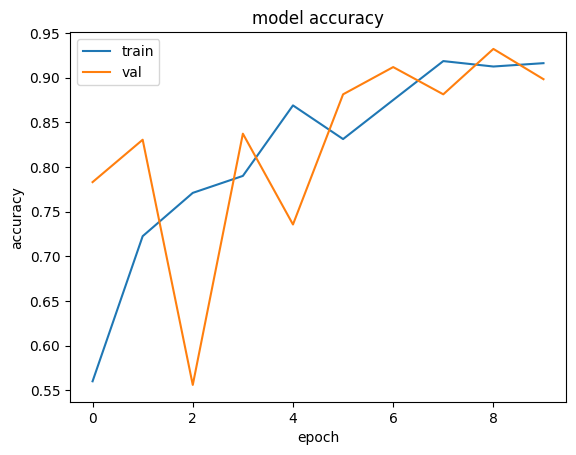

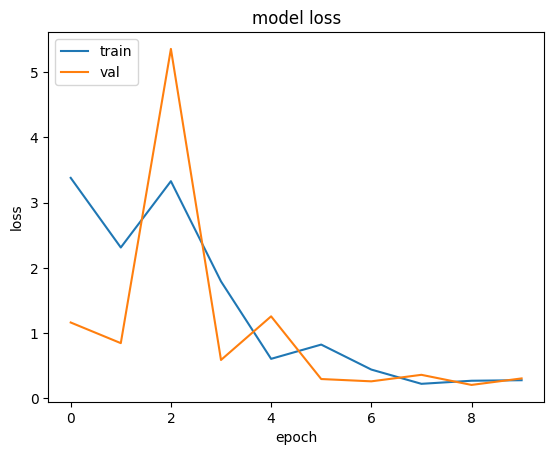

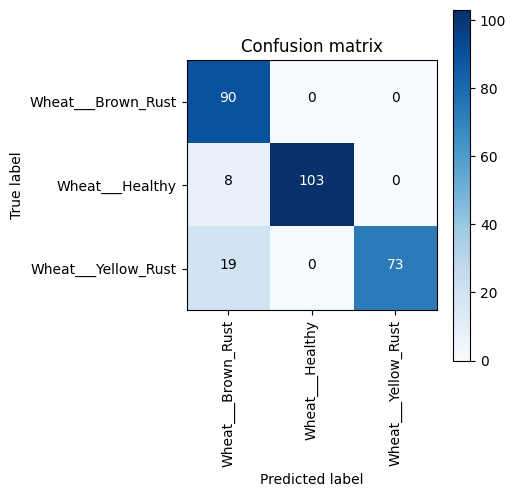

In [9]:
# INCEPTION V3

base_model = tensorflow.keras.applications.InceptionV3(
    weights = 'imagenet',
    include_top=False,
    input_shape=(229, 229, 3) # Topless
    )

#comparing transfer learning methods, keeping the output layers the same allows for a closer understanding of the differences
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
inception_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

#To compare pre-trained models accurately,
#train by freezing all parts up to the third-to-last layer.
#Freezing Convolutional Base
for layer in base_model.layers[:-3]:
    layer.trainable = False
    
import random
best_model_save = tensorflow.keras.callbacks.ModelCheckpoint(
    'InceptionV3' + str(random.randint(0,100000)) + '.hdf5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
)

metrics = ['accuracy']

inception_model.compile(loss='categorical_crossentropy',
              optimizer= tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), # tensorflow.keras.optimizers.RMSprop(learning_rate=1e-5)
              metrics=metrics)

inception_history = inception_model.fit(
      train_generator,
      epochs=10,
      steps_per_epoch = 50,
      validation_data = val_generator,
      callbacks = [best_model_save]
      )

evaluate_model(inception_model, inception_history, test_generator)

94765736/94765736 [==============================] - 9s 0us/step
Epoch 1/10
50/50 [==============================] - 150s 3s/step - loss: 3.8838 - accuracy: 0.5838 - val_loss: 2.6218 - val_accuracy: 0.3797
Epoch 2/10
50/50 [==============================] - 148s 3s/step - loss: 1.6770 - accuracy: 0.6825 - val_loss: 1.0953 - val_accuracy: 0.5898
Epoch 3/10
50/50 [==============================] - 142s 3s/step - loss: 0.9077 - accuracy: 0.7500 - val_loss: 1.2734 - val_accuracy: 0.5695
Epoch 4/10
50/50 [==============================] - 148s 3s/step - loss: 0.6137 - accuracy: 0.7713 - val_loss: 0.6301 - val_accuracy: 0.7254
Epoch 5/10
50/50 [==============================] - 141s 3s/step - loss: 0.7795 - accuracy: 0.7583 - val_loss: 2.1404 - val_accuracy: 0.5390
Epoch 6/10
50/50 [==============================] - 147s 3s/step - loss: 1.0818 - accuracy: 0.7237 - val_loss: 0.5130 - val_accuracy: 0.8102
Epoch 7/10
50/50 [==============================] - 141s 3s/step - loss: 0.7717 - accurac

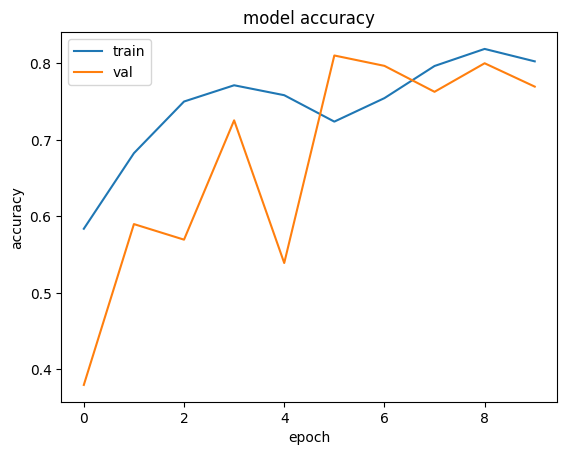

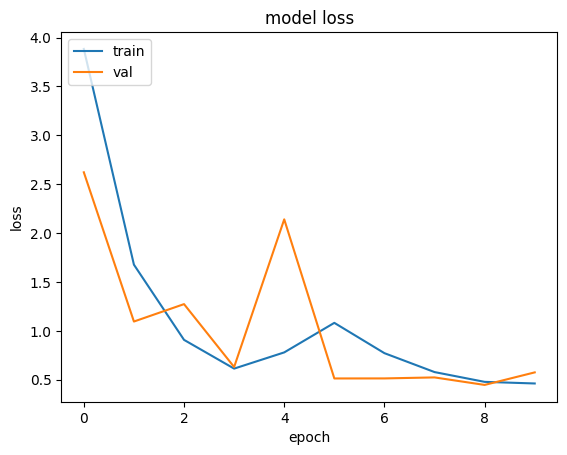

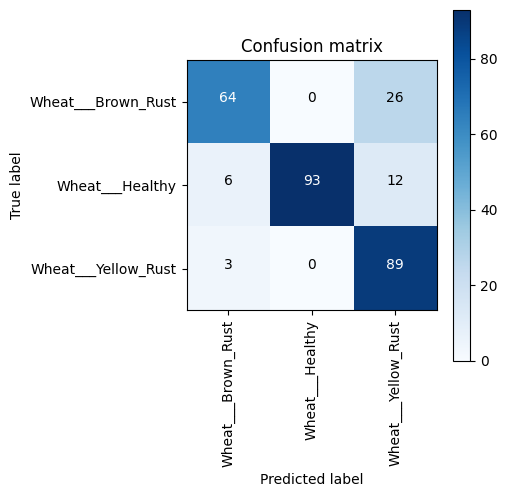

In [10]:
# RESNET50

base_model = tensorflow.keras.applications.ResNet50(
    weights = 'imagenet',
    include_top=False,
    input_shape=(200, 200, 3) # Topless
    ) 

#comparing transfer learning methods, keeping the output layers the same allows for a closer understanding of the differences
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
resnet_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

#To compare pre-trained models accurately,
#train by freezing all parts up to the third-to-last layer.
#Freezing Convolutional Base
for layer in base_model.layers[:-30]:
    layer.trainable = False

import random
best_model_save = tensorflow.keras.callbacks.ModelCheckpoint(
    'Resnet50' + str(random.randint(0,100000)) + '.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
)

metrics = ['accuracy']

resnet_model.compile(loss='categorical_crossentropy',
              optimizer= tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), # tensorflow.keras.optimizers.RMSprop(learning_rate=1e-5)
              metrics=metrics)

resnet_history = resnet_model.fit(
      train_generator,
      epochs=10,
      steps_per_epoch = 50,
      validation_data = val_generator,
      callbacks = [best_model_save]
      )

evaluate_model(resnet_model, resnet_history, test_generator)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_28 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 conv2d_29 (Conv2D)          (None, 218, 218, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 109, 109, 64)     0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 109, 109, 64)      0         
                                                           

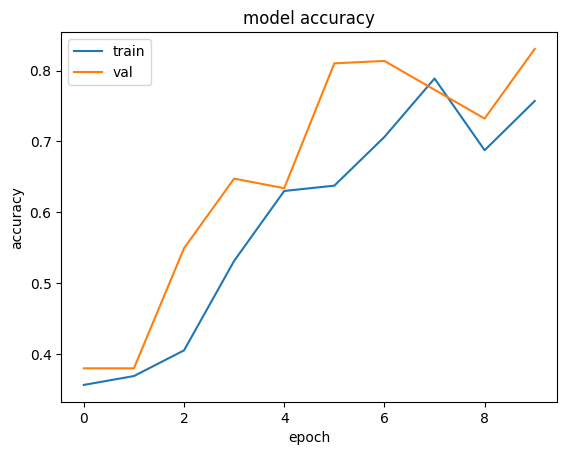

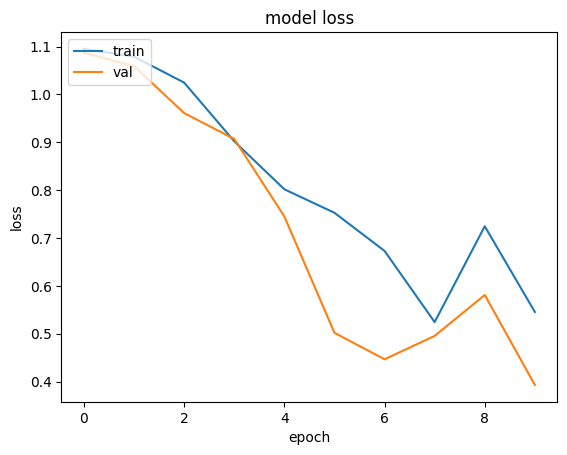

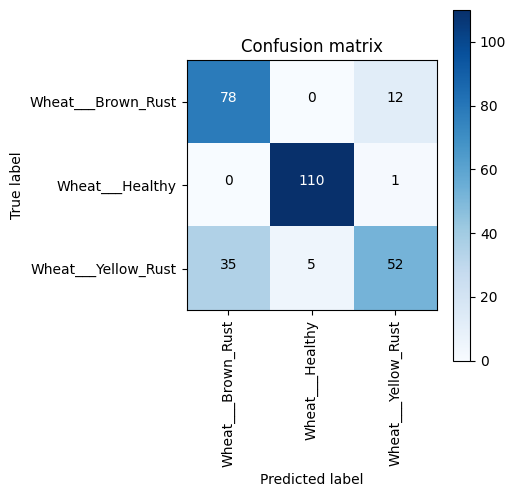

In [26]:
import keras
from keras.layers import Activation
from keras.models import Model, Sequential

inputs = keras.layers.Input((224, 224, 3))
x = keras.layers.Conv2D(64, (3,3), activation = 'relu')(inputs)
x = keras.layers.Conv2D(64, (3,3), activation = 'relu')(x)
x = keras.layers.Conv2D(64, (3,3), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(128, (3,3), activation = 'relu')(x)
x = keras.layers.Conv2D(128, (3,3), activation = 'relu')(x)
x = keras.layers.Conv2D(128, (3,3), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(256, (3,3), activation = 'relu')(x)
x = keras.layers.Conv2D(256, (3,3), activation = 'relu')(x)
x = keras.layers.Conv2D(256, (3,3), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(3, activation = "softmax")(x)
CNNmodel = Model(inputs = inputs, outputs = x)
print(CNNmodel.summary())

for layer in CNNmodel.layers:
    layer.trainable = True

import random
best_model_save = tensorflow.keras.callbacks.ModelCheckpoint(
    'CNN' + str(random.randint(0,100000)) + '.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
)

metrics = ['accuracy']

CNNmodel.compile(loss='categorical_crossentropy',
              optimizer= tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), # tensorflow.keras.optimizers.RMSprop(learning_rate=1e-5)
              metrics=metrics)

cnn_history = CNNmodel.fit(
      train_generator,
      epochs=10,
      steps_per_epoch = 50,
      validation_data = val_generator,
      callbacks = [best_model_save]
      )

evaluate_model(CNNmodel, cnn_history, test_generator)